In [14]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.func2 as func2
import mlgrad.weights as weights
from mlgrad.utils import exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.11.1 (main, Dec 31 2022, 10:23:59) [GCC 12.2.0]


/tmp/ipykernel_307114/701833256.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-ticks'])
/tmp/ipykernel_307114/701833256.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-ticks'])


In [6]:
df = pd.read_csv("data/animals.csv", sep=',')

In [7]:
len(df)

28

In [8]:
df

,name,body,brain
0,Mountain beaver,1.350,8.1
1,Cow,465.000,423.0
2,Grey wolf,36.330,119.5
3,Goat,27.660,115.0
4,Guinea pig,1.040,5.5
5,Dipliodocus,11700.000,50.0
6,Asian elephant,2547.000,4603.0
7,Donkey,187.100,419.0
8,Horse,521.000,655.0
9,Potar monkey,10.000,115.0


In [9]:
X = df["body"].values
Y = df["brain"].values

X = np.log(X)
Y = np.log(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [10]:
from sklearn.preprocessing import scale

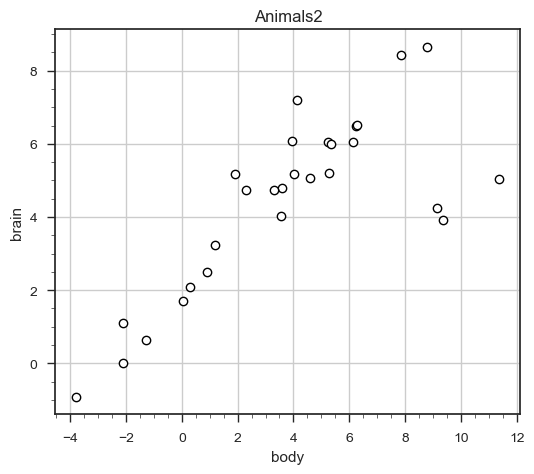

In [11]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=36, c='w', edgecolors='k', linewidths=1.)
plt.title('Animals2')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('body')
plt.ylabel('brain')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [12]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [15]:
sqr_norm = func2.SquareNorm()

In [16]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [17]:
mod_ls = model.LinearModel(1)
mod_ls.init_param()

K=1499 param=[2.5556605 0.4958736]


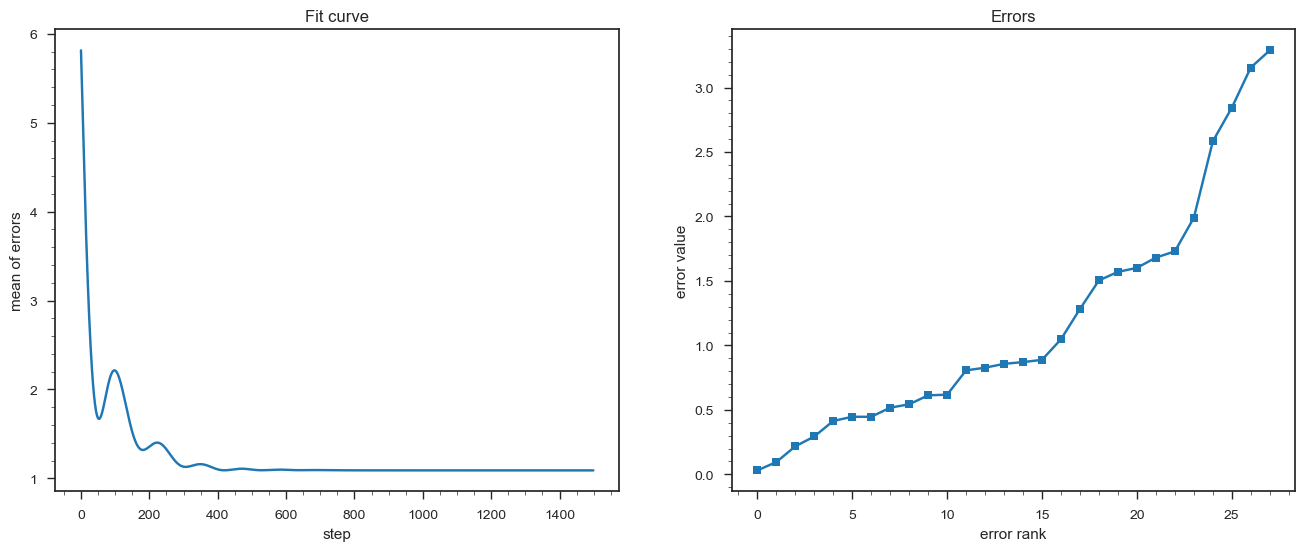

In [18]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, h=0.01, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [19]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init_param()

2.7490604445450697
K=69 param=[1.18002626 1.11498991]


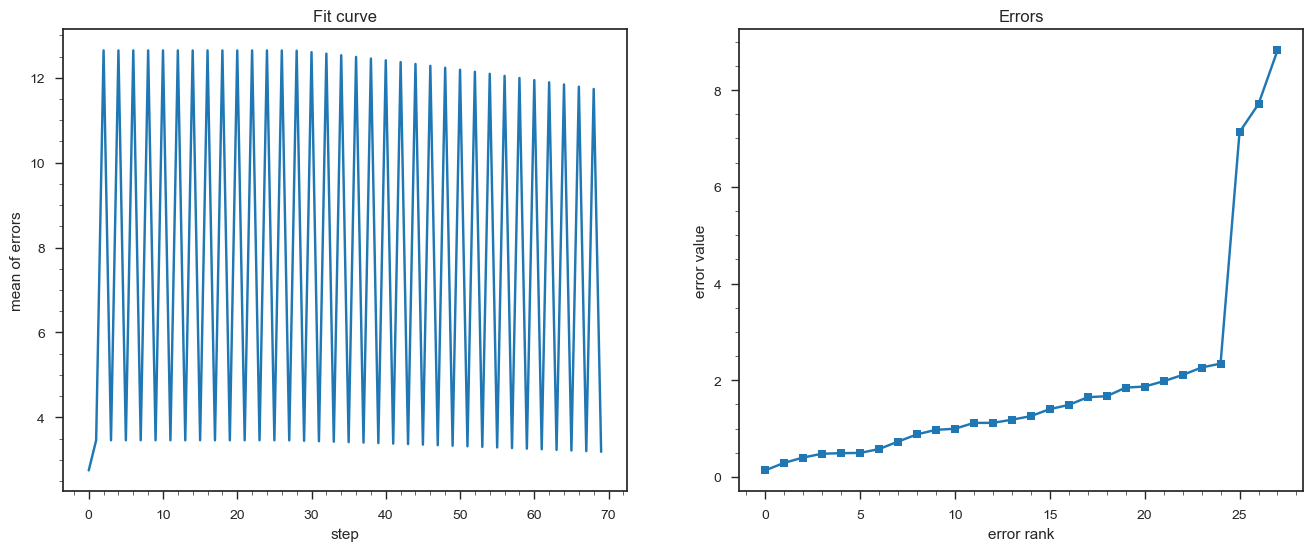

In [21]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.88, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, agg_func=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [22]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init_param()

0.3923053894804557
K=2 param=[2.28730603 0.77448633]


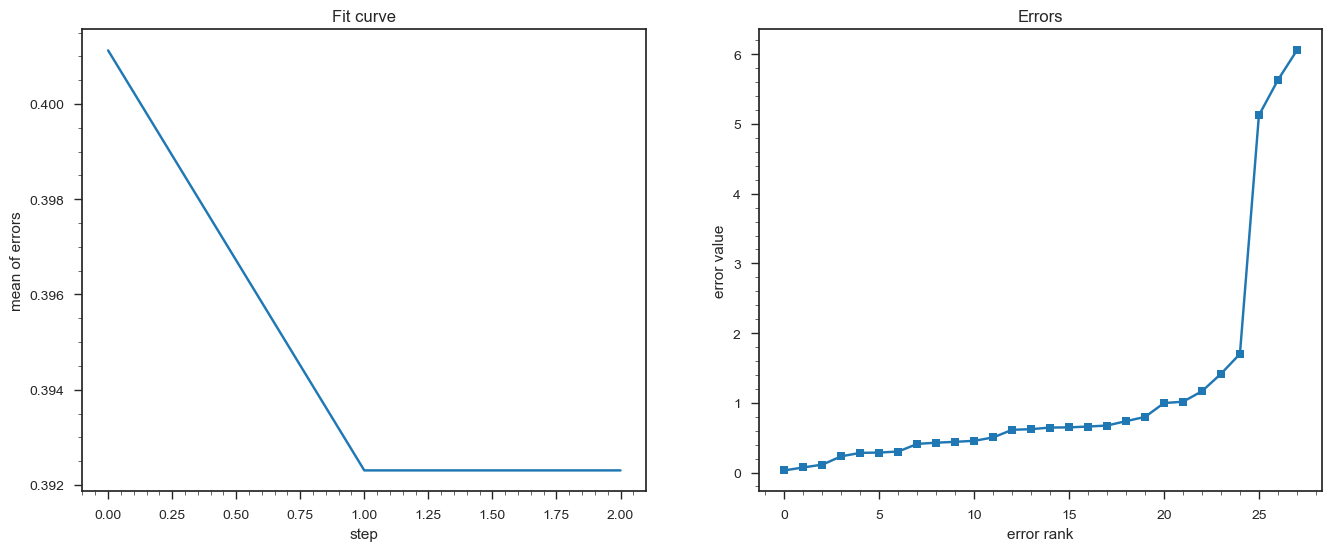

In [24]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.QuantileFunc(0.88, func.Sqrt(0.001)))
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, agg_func=avg_wm_irls, h=0.01, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [25]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init_param()

2.4685093688384803
K=6 param=[2.74336444 0.24960303]


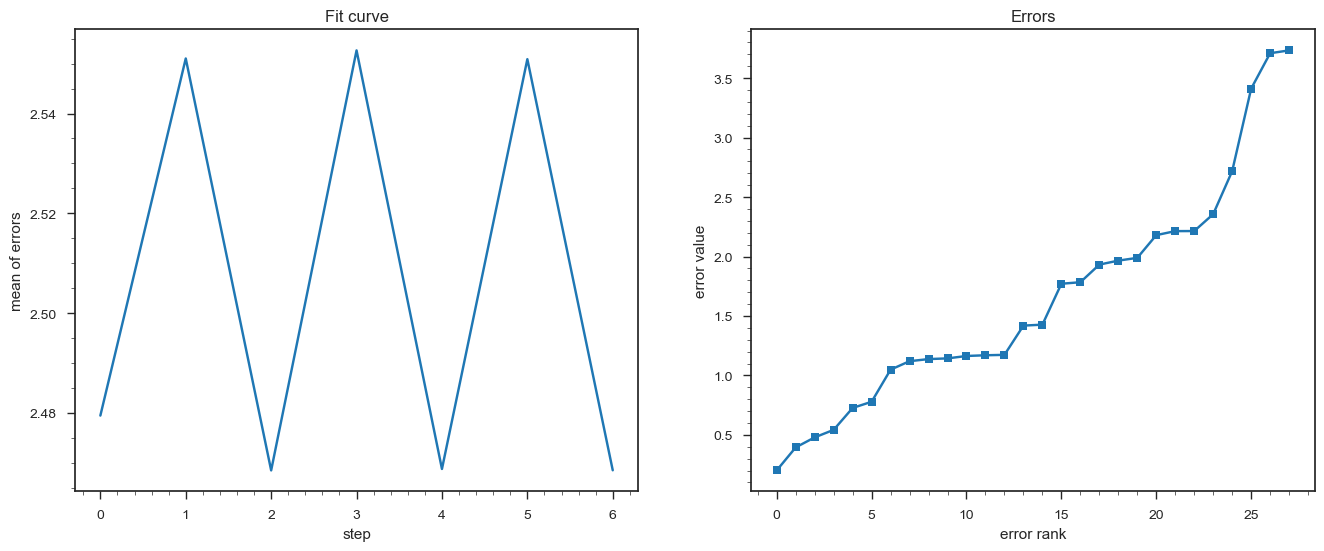

In [27]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.QuantileFunc(0.88, func.Sqrt(0.001)))
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, agg_func=avg_swm_irls, h=0.01, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [28]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [29]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init_param()

0.5765369619847376
K=6 param=[2.23730756 0.64578528]


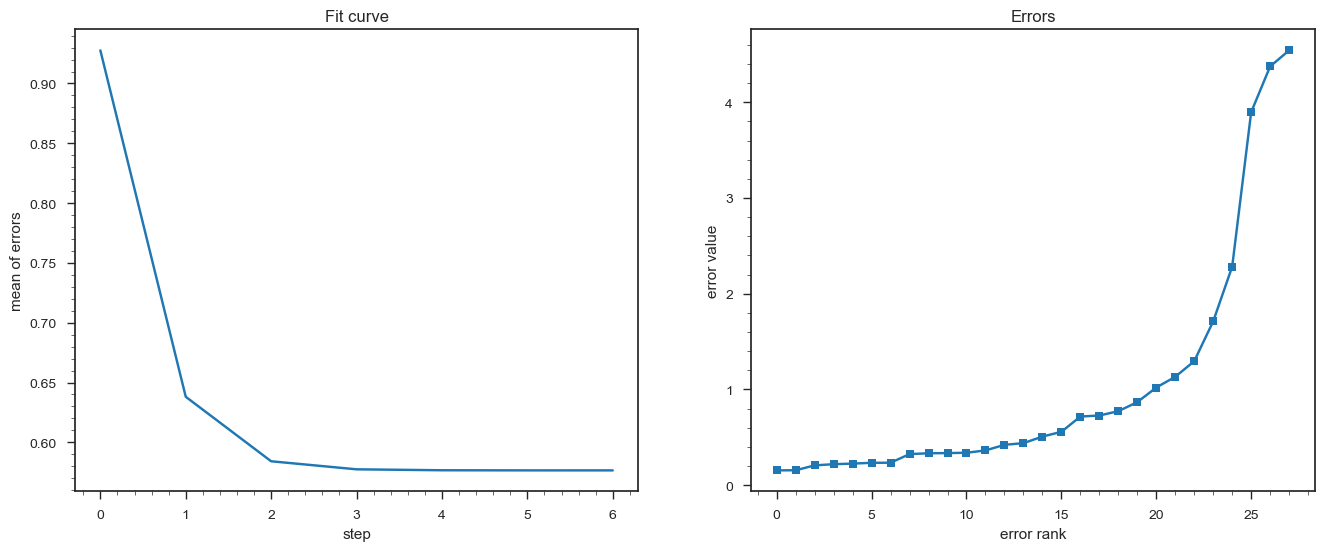

In [32]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rho_func=func.Sqrt(1.0), verbose=1)
err_r_irls = curve_fit_and_errors(alg_r_irls)

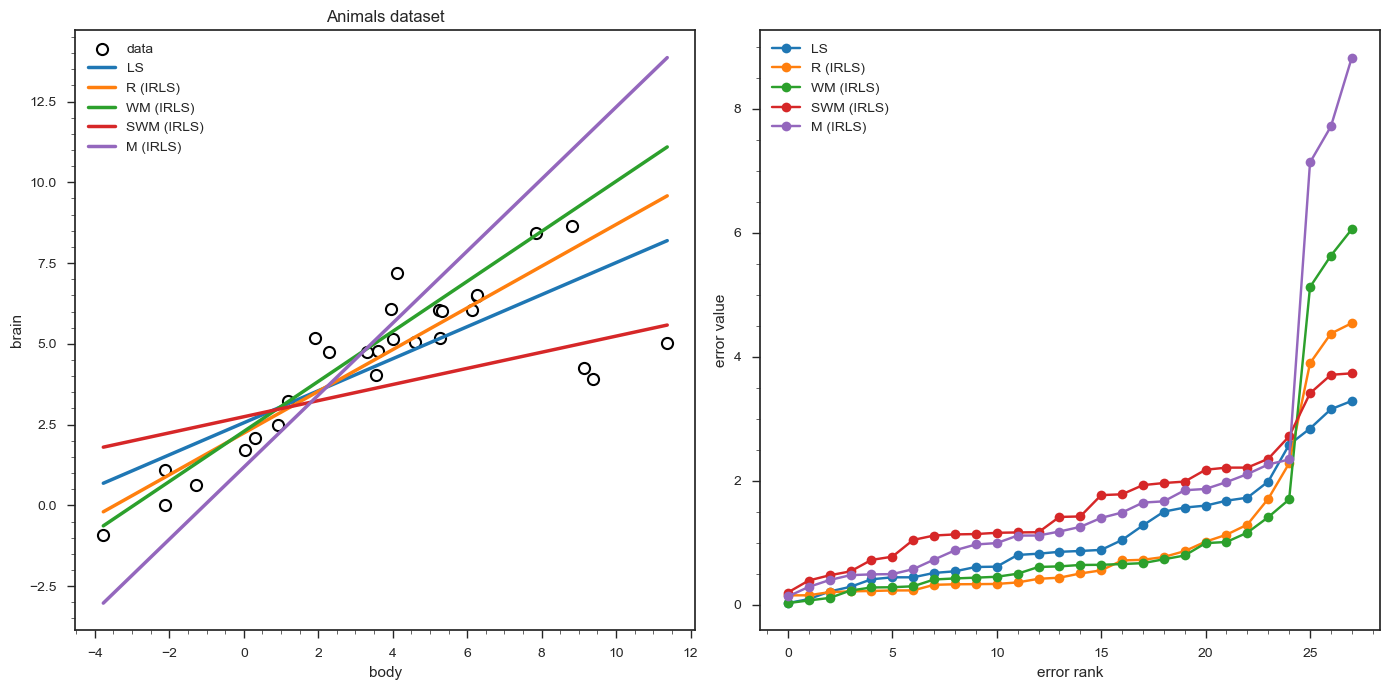

In [33]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('Animals dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('body')
plt.ylabel('brain')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
# plt.ylim(-0.1, 4.5)
# plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
(len(Y)-3)/len(Y)